In [1]:
import ee
import datetime
import pandas as pd
ee.Initialize()

In [3]:
def get_data(startTime,endTime,latlon):   

    try:
    #if(True):
        #Read Landsat 8 Image
        L8_DN = ee.ImageCollection('LANDSAT/LC8_L1T').filterDate(startTime, endTime)  
        emissivity = ee.Image('NASA/ASTER_GED/AG100_003').select('emissivity_band10').multiply(0.001) 
        srtm = ee.Image('USGS/SRTMGL1_003')
        impervious = ee.Image('USGS/NLCD/NLCD2011').select('impervious')
        
        # computes emissivity-corrected land surface temperature given Landsat8 band 10 (tir) and emissivity
        # assumes tir, emissivity are google earth engine images
        k1 = 774.8853 ; # constants for Landsat8 B10
        k2 =  1321.0789 ; # constants for Landsat8 B10
        dummyk1 = emissivity.multiply(0).add(1).multiply(k1) # make dummy variable same size/type as emissivity
        dummyk2 = emissivity.multiply(0).add(1).multiply(k2) # make dummy variable same size/type as emissivity
    
        df_all = pd.DataFrame()
        
        for loc in latlon[0:95:3]:
            try:
                point = {'type':'Point', 'coordinates':[loc[1],loc[0]]};
                L8_DN_point = L8_DN.filterBounds(point)    
                L8_DN_point = L8_DN_point.sort('CLOUD_COVER').first()  
    
                image = ee.Image(L8_DN_point)
                tir = image.select(u'B10')
                red = image.select(u'B4')
                nir = image.select(u'B5')
                ndvi = nir.subtract(red).divide(nir.add(red))
        
                # first convert band 10 Digital Number (DN) data to TOA spectral radiance
                radiance = tir.multiply(3.3420E-04).add(.1)  # scale by gain and bias, band specific 
                L_lamda = radiance.divide(emissivity); # correct for emissivity
                k1_over_L_lamda = dummyk1.divide(L_lamda) 
                denominator = k1_over_L_lamda.add(1).log(); 
                t = dummyk2.divide(denominator).subtract(273.15); # finally convert to degrees C 
    
                image = ee.ImageCollection(image)
                t = ee.ImageCollection(t)
                ndvi = ee.ImageCollection(ndvi)
                srtm = ee.ImageCollection(srtm)
                impervious = ee.ImageCollection(impervious)
    
                #Get the given Lat,Lon,date
                info = image.getRegion(point,500).getInfo()
                df_image = pd.DataFrame(info[1:],columns=info[0])
    
                #Get the LST (B10)
                info = t.getRegion(point,500).getInfo()
                df_t = pd.DataFrame(info[1:],columns=info[0])
    
                #Get the NDVI
                info = ndvi.getRegion(point,500).getInfo()
                df_ndvi = pd.DataFrame(info[1:],columns=info[0])

                #Get the SRTM
                info = srtm.getRegion(point,500).getInfo()
                df_srtm = pd.DataFrame(info[1:],columns=info[0])

                #Get the impervious
                info = impervious.getRegion(point,500).getInfo()
                df_impervious = pd.DataFrame(info[1:],columns=info[0])

                df = pd.DataFrame()
                df = pd.concat([df,df_image[['longitude','latitude','time']]],axis=1)
                df = pd.concat([df,df_t['emissivity_band10']],axis=1)
                df = pd.concat([df,df_ndvi['B5']],axis=1)
                df = pd.concat([df,df_srtm['elevation']],axis=1)
                df = pd.concat([df,df_impervious['impervious']],axis=1)
        
                df.rename(index=str, columns={"emissivity_band10": "LST"},inplace=True)
                df.rename(index=str, columns={"B5": "NDVI"},inplace=True)
                df['time'] = df['time'].apply(lambda x:datetime.datetime.fromtimestamp(float(str(x)[:-3])))
                df['latitude'] = loc[0]
                df['longitude'] = loc[1]
                
                df_all = pd.concat([df_all,df])
            except:
                df_all = df_all.copy()
            #print(shape(df_all))
        return df_all
    except:
        print("Not Found or Error!")
        return pd.DataFrame

In [4]:
import datetime
from matplotlib import dates
import matplotlib.dates as mdates
from pylab import *

startTime = datetime.datetime(2013, 1, 1)
endTime = datetime.datetime(2016, 1, 1)

collection = ee.ImageCollection('LANDSAT/LC8_L1T').filterDate(startTime, endTime)
point = {'type':'Point', 'coordinates':[ -117.2820,33.9802]};  # LA
info = collection.getRegion(point,500).getInfo()

# extract the header column names
header = info[0]
# create a Numpy array of the data
data = array(info[1:])
# extract the time information
iTime = header.index('time')
# convert to Python datetime objects
time_collection = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

In [5]:
#Read list of metereological station and
#Read the Temperature values from the Met stations
Tair_val = pd.read_csv('LAtmax.csv')
Tair_val.rename(index=str, columns={"day": "time"},inplace=True)
Tair_val.drop('ghcn_id',axis=1,inplace=True)

lat = Tair_val['latitude'].unique()
lon = Tair_val['longitude'].unique()
latlon = zip(lat,lon)

In [6]:
len(latlon)

95

In [7]:
import time as time

#Create the final Dataframe
df = pd.DataFrame()
counter=0

for time_X in time_collection[0:120:4]:
    tic = time.time()
    print(counter)
    startTime = time_X-datetime.timedelta(days=1)
    endTime = time_X+datetime.timedelta(days=1)
    df_temp = get_data(startTime,endTime,latlon)
    try:
        df = pd.concat([df,df_temp])
    except:
        df = df.copy()
    counter += 1
    
    toc = time.time()
    print(toc-tic)

0
77.0501189232
1
69.79865098
2
77.9301261902
3
81.6798410416
4
72.5418710709
5
78.387378931
6
65.8937911987
7
69.4765372276
8
66.2004230022
9
47.7379879951
10
68.630687952
11
82.7993938923
12
91.7868630886
13
80.6244680882
14
86.9696860313
15
56.0497069359
16
100.116712093
17
73.4625861645
18
71.6389389038
19
106.437191963
20
83.5372869968
21
95.5893568993
22
103.65345192
23
85.4740319252
24
93.8350758553
25
78.8909299374
26
86.0508890152
27
73.1298818588
28
74.5575420856
29
76.7479958534


In [9]:
df_copy = df.copy() #Keep a copy of the df dataframe

In [11]:
Tair_val.head()

,time,temp,latitude,longitude
0,2014-01-01,23.3,33.8647,-117.8425
1,2014-01-02,26.7,33.8647,-117.8425
2,2014-01-03,24.4,33.8647,-117.8425
3,2014-01-04,23.3,33.8647,-117.8425
4,2014-01-05,27.8,33.8647,-117.8425


In [12]:
#Do some field cleaning for joining the tables
df['longitude'] = df['longitude'].apply(lambda x:str(x)[0:8])
df['latitude'] = df['latitude'].apply(lambda x:str(x)[0:6])
df['time'] = df['time'].apply(lambda x:str(x.date()))

Tair_val['longitude'] = Tair_val['longitude'].apply(lambda x:str(x)[0:8])
Tair_val['latitude'] = Tair_val['latitude'].apply(lambda x:str(x)[0:6])
Tair_val['time'] = Tair_val['time'].apply(lambda x:str(x))

In [13]:
#Merge the two Tables
df = pd.merge(df, Tair_val, how='left', on=['latitude', 'longitude', 'time'])
#df.drop(['native_id','met_monitor_id'],axis=1,inplace=True)

ValueError: labels ['native_id' 'met_monitor_id'] not contained in axis

In [17]:
df = df.dropna(axis=0,how='any') #Drop any rows with missing data

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['longitude','latitude','time','temp'],axis=1), 
                                                    df['temp'], test_size=0.30, random_state=101)
#Do the Regression
#X_train = df.drop(['longitude','latitude','time','temp'], axis=1)
#y_train = df['temp']
                  

from sklearn.linear_model import LinearRegression
lm = LinearRegression(normalize=True)

lm.fit(X_train,y_train)

predictions_train = lm.predict(X_train)
predictions_test = lm.predict(X_test)

('MAE:', 4.0422104944686046)
('MSE:', 26.644173467160812)
('RMSE:', 5.161799440811393)


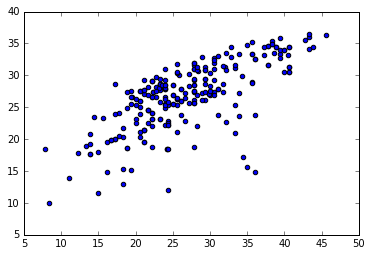

In [28]:
#Metrics for Training set
plt.scatter(y_train,predictions_train)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_train, predictions_train))
print('MSE:', metrics.mean_squared_error(y_train, predictions_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions_train)))

('MAE:', 5.0248910868420982)
('MSE:', 36.786258510700165)
('RMSE:', 6.0651676407746686)


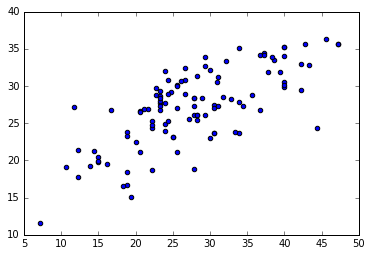

In [29]:
#Metrics for Test set
plt.scatter(y_test,predictions_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions_test))
print('MSE:', metrics.mean_squared_error(y_test, predictions_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_test)))

In [31]:
#with elevation
print(lm.coef_)
print(lm.intercept_)

[  2.26853597e-01  -1.81088546e+01  -3.39203608e-03  -5.62309315e-02]
26.6847981872


In [32]:
X_train.head()

,LST,NDVI,elevation,impervious
339,19.210572,0.067237,71,26
434,3.087713,0.149250,1384,0
207,51.750492,0.067372,815,0
431,20.511744,0.268772,124,0
353,25.404771,0.179257,604,0
